## To-do list
* Some cohort exploration based on deletion of subjects

* Look at variable correlations & clustering (if possible) -- suspect eg that systolic/diastolic will cluster based on prev work & means we can get away with using a variable score or one but not the other

* Create initial kitchen-sink model(s)
    * Identifier variables: ruid, visit_id, admit_date, discharge_date
    * Outcome variables: **readmit_30d**, readmit_time
    * Fixed effects (initially): ICD9, CPTs, medications, race, stay length, sex, DOB/age, pregnancy indicator, bmi
    * Random effects (initially): labs, number of transfers
    * Try as both: # transfers, stay length
    
    
* Do one model with all fixed effects first

* Model checking!!

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import bambi as bm
sns.set()

from sklearn import preprocessing, model_selection
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_auc_score

In [3]:
df = pd.read_csv('../data/merged.csv', parse_dates=['admit_date','discharge_date','dob','dod'])

In [4]:
hosp_dates = df.admit_date.dt
birthdays = df.dob.dt

# df['age'] = [hosp_dates.year - birthdays.year + ((hosp_dates.month < birthdays.month) & (hosp_dates.day < birthdays.day))]
times = zip(hosp_dates.year,hosp_dates.month,hosp_dates.day,birthdays.year,birthdays.month,birthdays.day)
df['age'] = [hyear - byear + ((hmon, hday) < (bmon, bday)) for (hyear,hmon,hday,byear,bmon,bday) in times]

In [5]:
df.sex = (df.sex == 'M')*1
df.race = df.race.astype('category')

In [6]:
df.head()

,ruid,visit_id,admit_date,discharge_date,stay_length,n_transfers,readmit_time,readmit_30d,sex,dob,...,k,na,pcv,plt-ct,systolic,diastolic,bmi,pregnancy_indicator,egfr,age
0,50135262,0,2007-02-08,2007-02-12,4 days 00:00:00.000000000,2,172 days 00:00:00.000000000,0,0,1949-09-20,...,4.40,136.0,32.0,334.0,140.0,58.0,44.710,0.0,123.677830,59
1,50135262,1,2007-08-03,2007-08-06,3 days 00:00:00.000000000,3,22 days 00:00:00.000000000,1,0,1949-09-20,...,4.45,135.0,39.0,291.5,121.0,61.0,45.025,0.0,89.505000,59
2,50135262,2,2007-08-28,2007-08-29,1 days 00:00:00.000000000,1,179 days 00:00:00.000000000,0,0,1949-09-20,...,3.90,139.0,38.0,308.0,131.0,60.0,46.230,0.0,107.450000,59
3,50135262,3,2008-02-24,2008-02-28,4 days 00:00:00.000000000,2,44 days 00:00:00.000000000,0,0,1949-09-20,...,4.00,135.0,38.0,274.0,151.0,74.0,47.140,0.0,73.010770,60
4,50135262,4,2008-04-12,2008-04-13,1 days 00:00:00.000000000,1,928 days 00:00:00.000000000,0,0,1949-09-20,...,4.10,139.0,36.0,330.0,134.0,66.0,47.360,0.0,84.358415,60


In [7]:
df.shape

(21041, 67)

In [8]:
df.columns

Index(['ruid', 'visit_id', 'admit_date', 'discharge_date', 'stay_length',
       'n_transfers', 'readmit_time', 'readmit_30d', 'sex', 'dob', 'dod',
       'race', 'cpt_anesthesia', 'cpt_eval_manage', 'cpt_expired',
       'cpt_medicine', 'cpt_modifier', 'cpt_path_lab', 'cpt_radiology',
       'cpt_surgery', 'cpt_unknown', 'icd_dx_blood', 'icd_dx_circulatory',
       'icd_dx_congenital', 'icd_dx_digestive', 'icd_dx_endocrine',
       'icd_dx_external', 'icd_dx_gu', 'icd_dx_infection', 'icd_dx_injury',
       'icd_dx_mental', 'icd_dx_muscskel', 'icd_dx_neoplasm', 'icd_dx_nervous',
       'icd_dx_obstetric', 'icd_dx_perinatal', 'icd_dx_respiratory',
       'icd_dx_skin', 'icd_dx_symptoms', 'icd_proc', 'icd_visit',
       'med_Antihypertensive Agents', 'med_Analgesics, Opioid',
       'med_Narcotics', 'med_Antipyretics', 'med_Anti-Bacterial Agents',
       'med_Anti-Inflammatory Agents, Non-Steroidal',
       'med_Analgesics, Non-Narcotic', 'med_Antiemetics', 'med_Diuretics',
       'med_A

In [11]:
labs = ['bun', 'co2', 'cl', 'creat', 'glubed',
       'gluc', 'k', 'na', 'pcv', 'plt-ct', 'systolic', 'diastolic', 'egfr']

demo = ['sex', 'age', 'bmi', 'pregnancy_indicator', 'race']

visit = ['stay_length', 'n_transfers', 'cpt_anesthesia', 'cpt_eval_manage', 'cpt_expired',
       'cpt_medicine', 'cpt_modifier', 'cpt_path_lab', 'cpt_radiology',
       'cpt_surgery', 'cpt_unknown']

diagnosis = ['icd_dx_blood', 'icd_dx_circulatory',
       'icd_dx_congenital', 'icd_dx_digestive', 'icd_dx_endocrine',
       'icd_dx_external', 'icd_dx_gu', 'icd_dx_infection', 'icd_dx_injury',
       'icd_dx_mental', 'icd_dx_muscskel', 'icd_dx_neoplasm', 'icd_dx_nervous',
       'icd_dx_obstetric', 'icd_dx_perinatal', 'icd_dx_respiratory',
       'icd_dx_skin', 'icd_dx_symptoms', 'icd_proc', 'icd_visit']

meds = ['med_Antihypertensive Agents', 'med_Analgesics, Opioid',
       'med_Narcotics', 'med_Antipyretics', 'med_Anti-Bacterial Agents',
       'med_Anti-Inflammatory Agents, Non-Steroidal',
       'med_Analgesics, Non-Narcotic', 'med_Antiemetics', 'med_Diuretics',
       'med_Anti-Arrhythmia Agents']

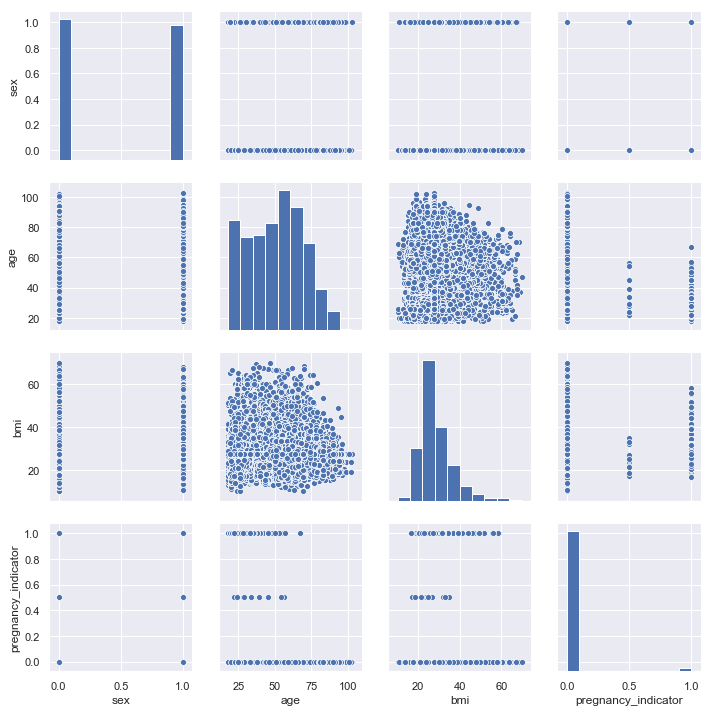

In [9]:
sns.pairplot(df[demo]);

In [10]:
df[((df.sex == 1) & (df.pregnancy_indicator == 1)) | ((df.sex == 1) & (df.pregnancy_indicator == 1)).shift() | ((df.sex == 1) & (df.pregnancy_indicator == 1)).shift(-1)]

,ruid,visit_id,admit_date,discharge_date,stay_length,n_transfers,readmit_time,readmit_30d,sex,dob,...,k,na,pcv,plt-ct,systolic,diastolic,bmi,pregnancy_indicator,egfr,age
2282,53728500,0,2006-05-06,2006-05-09,3 days 00:00:00.000000000,1,9999 days 00:00:00.000000000,0,0,1943-07-18,...,3.40,138.5,39.5,191.5,130.0,70.0,22.260,0.0,97.308400,64
2283,53728502,0,2004-10-28,2004-11-02,5 days 00:00:00.000000000,1,78 days 00:00:00.000000000,0,1,1949-10-25,...,4.10,136.0,35.0,323.0,126.0,66.0,36.800,1.0,99.935990,55
2284,53728502,1,2005-01-19,2005-01-26,7 days 00:00:00.000000000,5,307 days 00:00:00.000000000,0,1,1949-10-25,...,3.70,131.5,28.0,274.0,126.0,66.0,36.800,1.0,11.323180,57
2285,53728502,2,2005-11-29,2005-12-02,3 days 00:00:00.000000000,1,26 days 00:00:00.000000000,1,1,1949-10-25,...,4.30,137.0,28.0,294.0,128.0,70.0,33.970,0.5,45.307285,56
5965,53730004,5,2010-01-05,2010-01-08,3 days 00:00:00.000000000,1,54 days 00:00:00.000000000,0,1,1972-05-05,...,4.95,139.5,35.0,404.0,140.5,80.0,21.950,0.0,4.885000,39
5966,53730004,6,2010-03-03,2010-03-08,5 days 00:00:00.000000000,3,26 days 00:00:00.000000000,1,1,1972-05-05,...,4.55,138.0,35.0,160.0,111.0,66.0,22.095,1.0,7.252745,39
5967,53730004,7,2010-04-03,2010-04-28,25 days 00:00:00.000000000,17,11 days 00:00:00.000000000,1,1,1972-05-05,...,3.95,137.0,26.0,623.0,127.0,75.0,20.980,1.0,13.350000,39
5968,53730004,8,2010-05-09,2010-05-15,6 days 00:00:00.000000000,4,19 days 00:00:00.000000000,1,1,1972-05-05,...,4.40,139.0,36.5,349.0,122.0,80.0,22.020,0.0,13.653300,38
5969,53730004,9,2010-06-03,2010-06-24,21 days 00:00:00.000000000,15,32 days 00:00:00.000000000,0,1,1972-05-05,...,4.20,139.0,31.0,414.0,120.0,76.0,22.670,1.0,15.670100,38
5970,53730004,10,2010-07-26,2010-07-29,3 days 00:00:00.000000000,4,9999 days 00:00:00.000000000,0,1,1972-05-05,...,4.95,137.5,40.0,288.0,138.0,81.0,21.940,1.0,20.870240,38


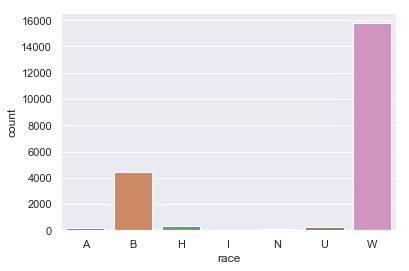

In [14]:
sns.countplot(df.race);

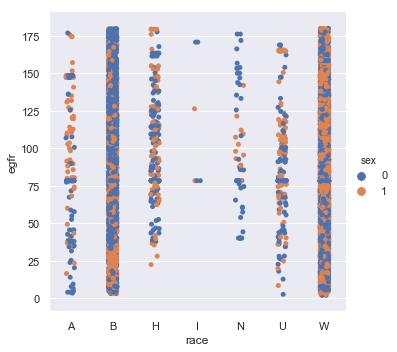

In [23]:
sns.catplot(x = 'race', y = 'egfr', hue='sex', data=df);

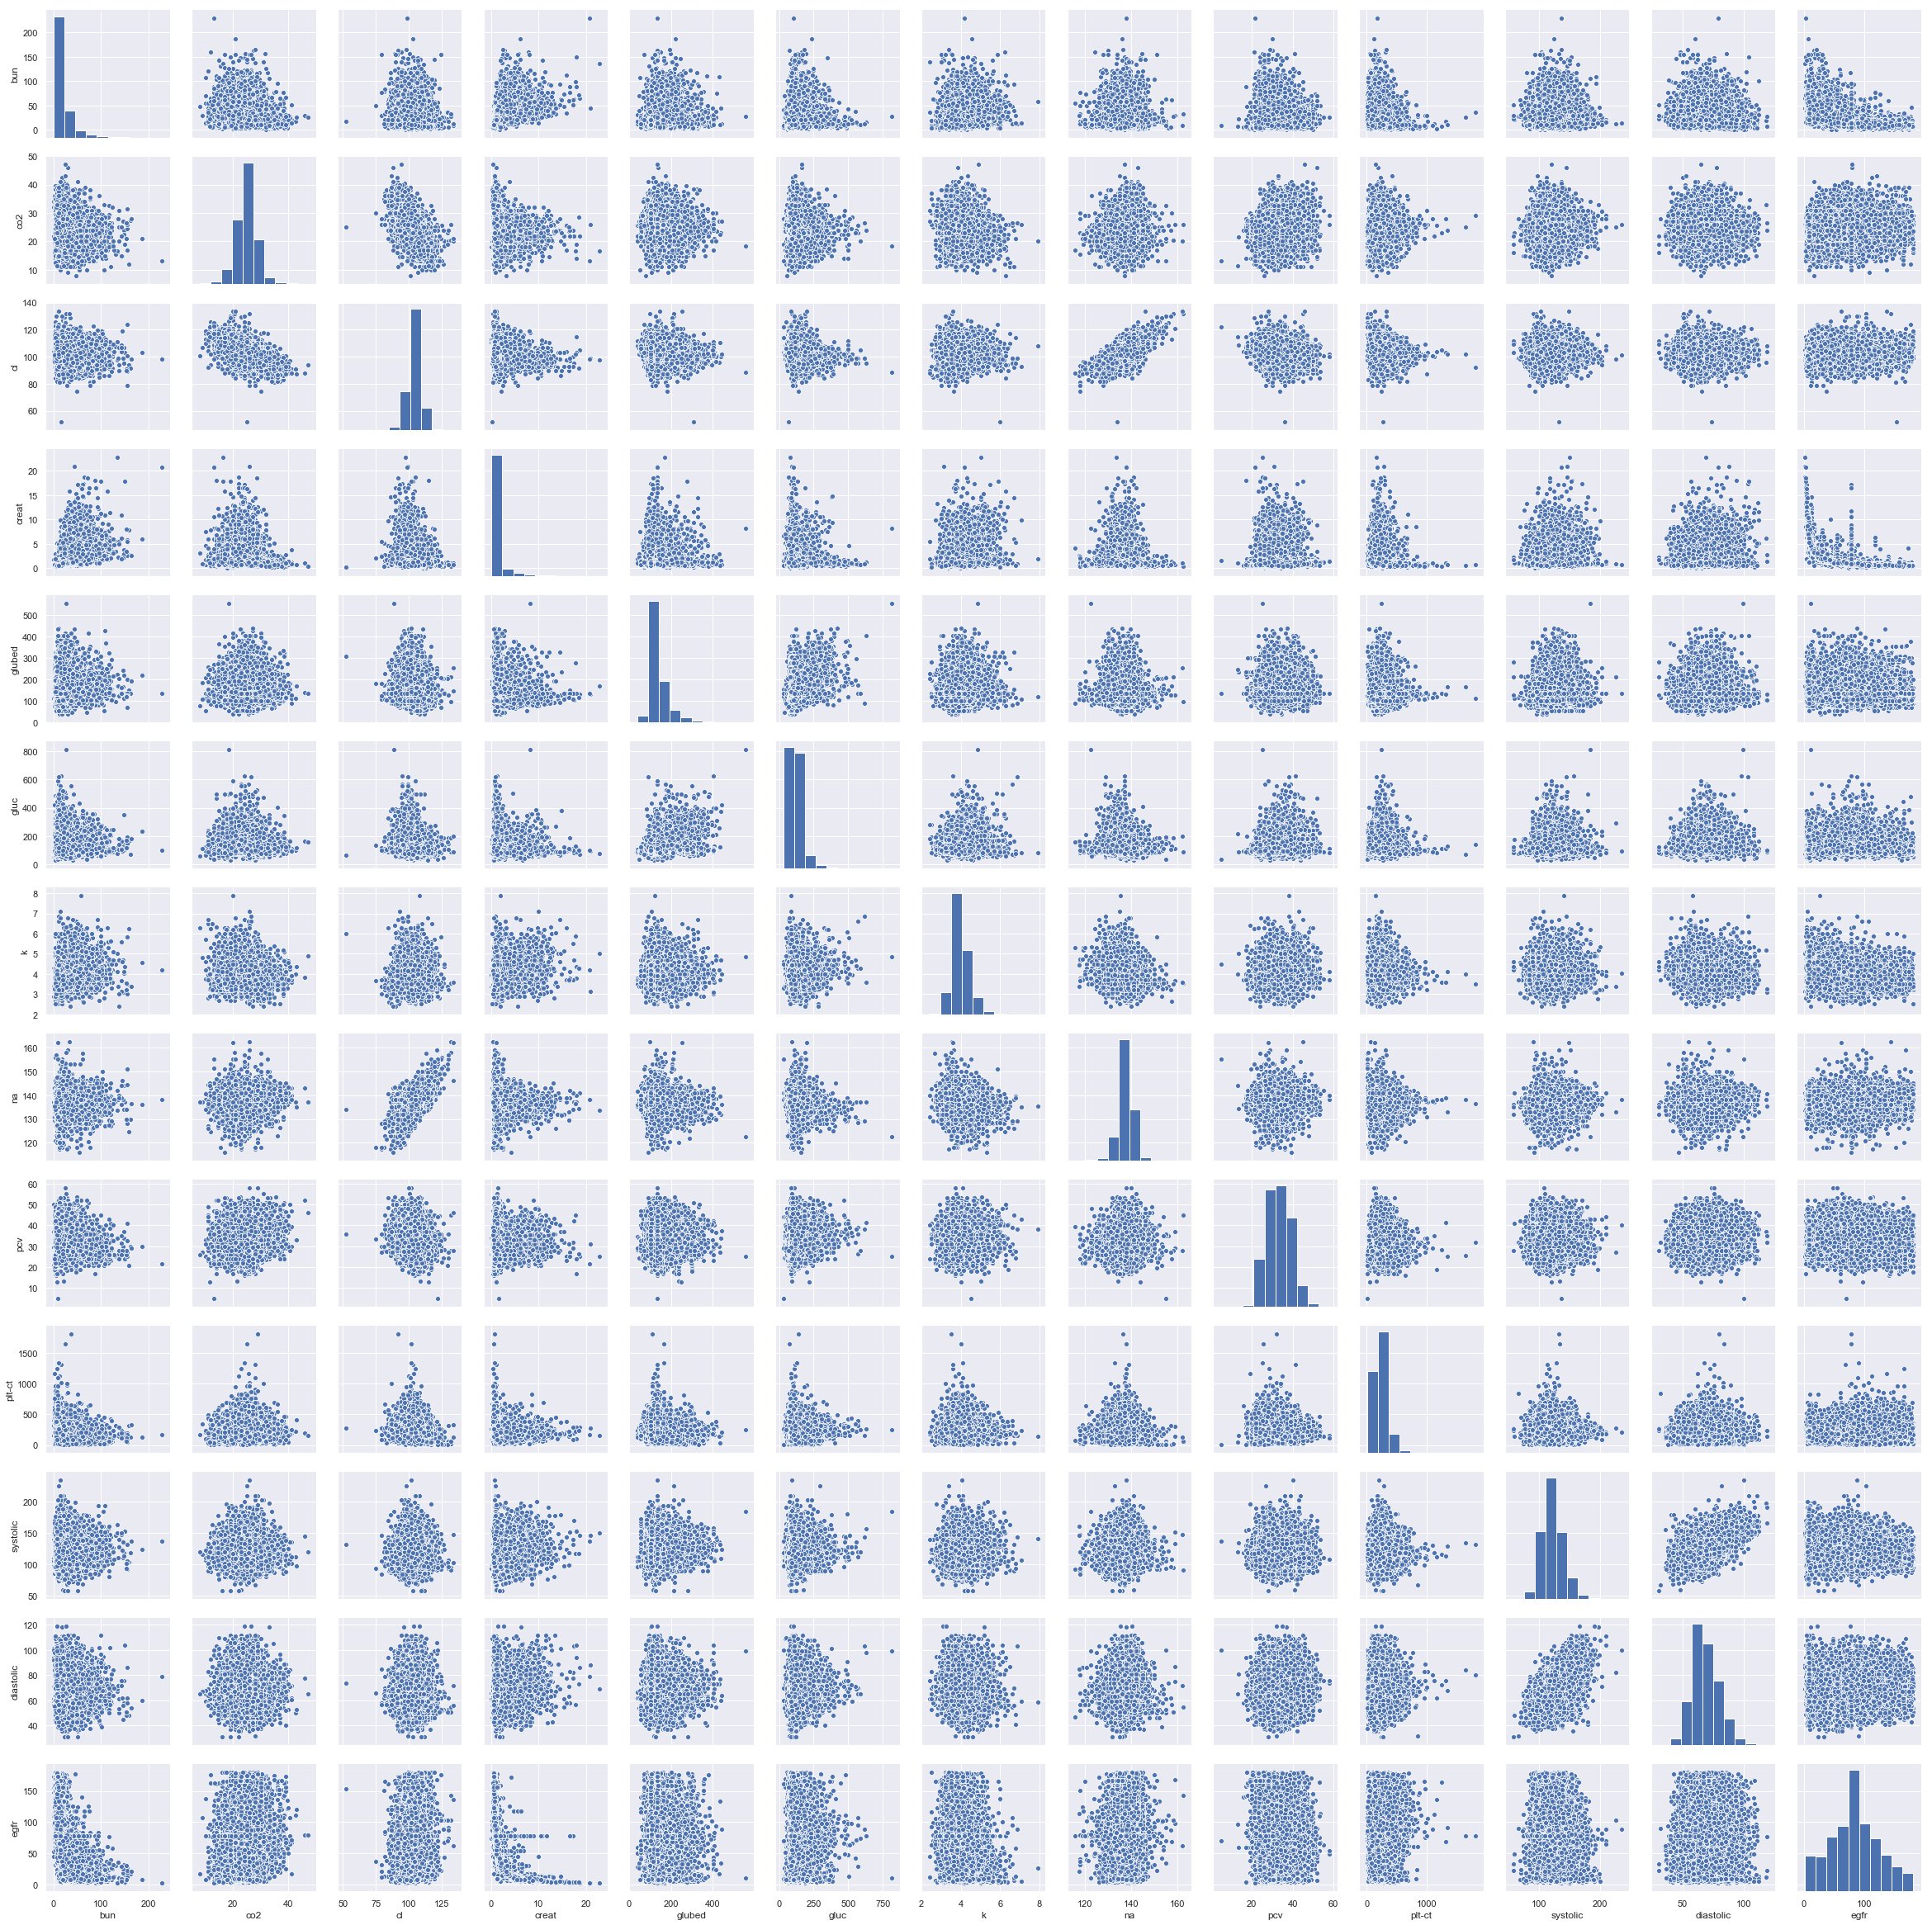

In [22]:
sns.pairplot(df[labs]);

In [25]:
# minimal_model = bm.Model(df)

# form = 'readmit_30d ~ ' + ' + '.join(demo)

# minimal_model.add('readmit_30d ~ 1')

# minimal_model.add(fixed = ' + '.join(demo))

In [44]:
y = df.readmit_30d
X = df[['ruid'] + demo]
X.loc[X.pregnancy_indicator.isna(),'pregnancy_indicator'] = 0
bmi = X.pop('bmi').values
bmi = bmi - bmi.mean()
ruid = X.ruid.unique()
N = len(ruid)

/Users/kkondratieff/anaconda/envs/bios8366/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [41]:
X.pregnancy_indicator.isna().sum()

In [42]:
bmi

array([44.71 , 45.025, 46.23 , ..., 31.43 ,    nan, 29.91 ])

In [26]:
with Model() as minimal_model:
    
    bmi_imputed = pm.Normal('bmi_imputed',0,s, observed=np.ma.masked_invalid(bmi))
    
    
    μ
    

In [ ]:
pm.model_to_graphviz(minimal_model)